# 1차 시도를 극복해보자

### -> 총 3가지 도전을 해볼 것이다.

1) resnet으로 예측

2) 내 모델을 224 by 224 by 3에 맞게 만들어져 있으니깐 mnist를 224 by 224로 만들어서 학습시키고 예측해보자("해상도를 높였으니 잘 알아보지 않을까??"라는 가능성의 실험)

3) 그레이 스케일을 잘 해보자(유튜브 참고)

## 1) resnet으로 예측

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import numpy as np
import cv2

# include_top을 하면 vgg 분류기까지 가져온다는 얘기
model = VGG16(weights='imagenet', include_top=True) 
model.compile(optimizer='sgd', loss='categorical_crossentropy')

# resize into VGG16 trained images' format
im = cv2.resize(cv2.imread('/content/123.jpg'), (224, 224))
im = np.expand_dims(im, axis=0) # 1, 224, 224, 3이 됨
# im = im.reshape(1,im.shape[0],im.shape[1], im.shape[2])
im.astype(np.float32)

print(type(im))

# predict
out = model.predict(im)
index = np.argmax(out)
print(index)

#plt.plot(out.ravel())
#plt.show()

<class 'numpy.ndarray'>


281


# 넘파이화 실험

-> 입력 이미지를 반드시 넘파이화 해야 모델 학습을 할 수 있다.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import numpy as np
import cv2

# include_top을 하면 vgg 분류기까지 가져온다는 얘기
model = VGG16(weights='imagenet', include_top=True) 
model.compile(optimizer='sgd', loss='categorical_crossentropy')

# resize into VGG16 trained images' format
im = cv2.resize(cv2.imread('/content/123.jpg'), (224, 224))
im = np.array(im)
im = np.expand_dims(im, axis=0) # 1, 224, 224, 3이 됨
im.astype(np.float32)

print(type(im))

# predict
out = model.predict(im)
index = np.argmax(out)
print(index)

#plt.plot(out.ravel())
#plt.show()

<class 'numpy.ndarray'>
281


### 2) 내 모델을 224 by 224 by 3에 맞게 만들고 mnist를 224 by 224로 만들어서 학습시키고 높은 해상도로 예측해보자

궁금증 : 어떠한 경우에 모델 input이 32, 32이고 어떨떈 32, 32, 3이지? -> 채널이 1이 아니면 무조건 3을 붙어야 하나?
<br><br>

해결 : 3차원 컬러 이미지이면 모델 input shape를 32 * 32 * 3으로하고 학습 이미지도 60000 * 32 * 32 * 3으로 reshape해야하고 inference로 넣을 이미지도 1 * 32 * 32 * 3으로 넣어야한다.

-> 하지만 1차원 이미지이면 컬러 차원을 넣을 필요가 없다.


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import cv2

#define the convnet 
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = models.Sequential()
		# CONV => RELU => POOL
		model.add(layers.Convolution2D(20, (5, 5), activation='relu',
			input_shape=INPUT_SHAPE))
		model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# CONV => RELU => POOL
		model.add(layers.Convolution2D(50, (5, 5), activation='relu'))
		model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		# Flatten => RELU layers
		model.add(layers.Flatten())
		model.add(layers.Dense(500, activation='relu'))
		# a softmax classifier
		model.add(layers.Dense(classes, activation="softmax"))
		return model



# network and training
EPOCHS = 5
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = tf.keras.optimizers.Adam()
VALIDATION_SPLIT=0.90

IMG_ROWS, IMG_COLS = 224, 224 # input image dimensions
INPUT_SHAPE = (IMG_ROWS, IMG_COLS)
NB_CLASSES = 10  # number of outputs = number of digits

# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# reshape
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))



print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


cv로 하면 한장 한장씩 resize 해야하는데? tf로하면 한 번에 된다. 하지만 mnist의 경우 60000만 장으로 동작 도중 연결이 끊긴다.

-> resize랑 reshape만 잘쓰면 되네~ 근데 mnist 784개가 224 * 224만큼 안 나와서 안된다.

In [ ]:
# im = cv2.resize(cv2.imread('/content/123.jpg'), (224, 224))
# X_train = cv2.resize(X_train, (224, 224))
# X_test = cv2.resize(X_test, (224, 224))

In [ ]:
# X_train = tf.image.resize(X_train, [224, 224])
# X_test = tf.image.resize(X_test, [224, 224])
# print(X_train.shape, X_test.shape)

In [ ]:
img = img.reshape((-1, 28, 28, 1))

In [ ]:
for i in range(X_train.shape[0]):
  X_train[i] = X_train[i].reshape((-1, 224, 224, 1))

print(X_train)

ValueError: ignored

In [ ]:
# normalize
X_train, X_test = X_train / 255.0, X_test / 255.0

# cast
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, NB_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NB_CLASSES)

# initialize the optimizer and model
model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])
model.summary()

# use TensorBoard, princess Aurora!
callbacks = [
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

# fit 
history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=EPOCHS, 
		verbose=VERBOSE, validation_split=VALIDATION_SPLIT,
		callbacks=callbacks)

score = model.evaluate(X_test, y_test, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

# 끊질긴 노력 끝에 성공~

# 3) gray scale 

https://copycoding.tistory.com/225

○ CV

-> 이미지 입력 shape 전처리 단계 정리

1.img = cv2.imread("/content/제목 없음.png", cv2.2/IMREAD_GRAYSCALE)

2.img = cv2.resize(255-img, (28, 28)) # 이것만 해도 원래 안됐던 reshape은 됨

3.img = img.flatten() / 255.0

4.img = img.reshape((-1, 28, 28, 1))
<br><br>
※부수적인 것 : 5. 실수화 : im.astype(np.float32) ↑ 이 위에서 넘파이화는 이미 되어있다/

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import cv2

In [ ]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

In [ ]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 1
IMG_ROWS = 28
IMG_COLS = 28

#constant
BATCH_SIZE = 128
EPOCHS = 20
CLASSES = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = tf.keras.optimizers.RMSprop()

#define the convnet 
def build(input_shape, classes):
	model = models.Sequential() 
	model.add(layers.Convolution2D(32, (3, 3), activation='relu',
                        input_shape=input_shape))
	model.add(layers.MaxPooling2D(pool_size=(2, 2)))
	model.add(layers.Dropout(0.25)) 

	model.add(layers.Flatten())
	model.add(layers.Dense(512, activation='relu'))
	model.add(layers.Dropout(0.5))
	model.add(layers.Dense(classes, activation='softmax'))
	return model

y_train = tf.keras.utils.to_categorical(y_train, CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, CLASSES)

model=build((IMG_ROWS, IMG_COLS, IMG_CHANNELS), CLASSES)
# model=build((IMG_ROWS, IMG_COLS), CLASSES)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=OPTIM,
	metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 512)               2769408   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
 451/1875 [======>.......................] - ETA: 1:44 - loss: 0.3646 - accuracy: 0.8872

KeyboardInterrupt: ignored

In [ ]:
score = model.evaluate(X_test, y_test, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

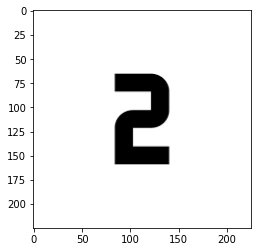

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = cv2.imread('/content/다운로드.png')
plt.imshow(img)

In [ ]:
img.shape

(225, 225, 3)

In [ ]:
img = cv2.resize(img, (28, 28))

In [ ]:
img.shape

(28, 28, 3)

In [ ]:
import cv2
img = cv2.imread("/content/제목 없음.png", cv2.IMREAD_GRAYSCALE)

In [ ]:
img.shape

(296, 323)

In [ ]:
img = cv2.resize(255-img, (28, 28)) # 이것만 해도 원래 안됐던 reshape은 됨

In [ ]:
img = img.flatten() / 255.0
img = img.reshape((-1, 28, 28, 1))

In [ ]:
img.shape

(3, 28, 28, 1)

In [ ]:
img = img.reshape((3, 28, 28))

In [ ]:
img.shape

(3, 28, 28)

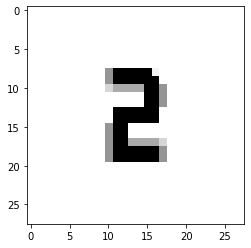

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
img.permute(1, 2, 0)

AttributeError: ignored

In [ ]:
y_prob = model.predict(img, verbose=0) 
predicted = y_prob.argmax(axis=-1)

# 0 ~ 9 중 3번째인 2를 3이라고 잘 예측한다!!

-> 이 프로젝트는 지금까지 모델을 훈련하고 검증만 해봤지 실제 사용해 본 경험이 없어 도전한 것이었고 이미지 처리에서 배운게 많은 경험이었다.

In [ ]:
print(predicted)

[3]
